## **Project 2 : Digit Recognizer**
Source : https://www.kaggle.com/c/digit-recognizer </br>
Reff : </br> https://www.kaggle.com/pybear/cnn-100-transfer-learning-data-augmentation</br>
https://www.kaggle.com/devishu14/how-yann-lecunn-implemented-cnn

### **Step 1 : Data Preparation**

In [ ]:
#import library yang di perlukan
import zipfile
import os
import shutil
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#import image dataset from kaggle
!kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.2MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 82.6MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 72.6MB/s]


In [ ]:
# Ekstraksi file .zip
with zipfile.ZipFile('/content/test.csv.zip', 'r') as test_data:
  test_data.extractall('/content/')
with zipfile.ZipFile('/content/train.csv.zip', 'r') as train_data:
  train_data.extractall('/content/')

In [ ]:
!ls

gdrive	     sample_submission.csv  test.csv.zip  train.csv.zip
sample_data  test.csv		    train.csv


### **Step 2 : Data Pre-Processing**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_sample = pd.read_csv('sample_submission.csv')

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_sample.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### **Step 3 : First Visualization**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

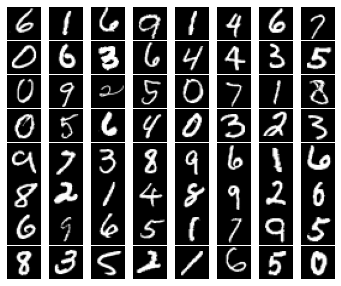

In [ ]:
train_clean = df_train.iloc[:, 1:] 
test_clean = df_test 

rand_indices = np.random.choice(train_clean.shape[0], 64, replace=False)
examples = train_clean.iloc[rand_indices, :]

fig, ax_arr = plt.subplots(8, 8, figsize=(6, 5))
fig.subplots_adjust(wspace=.025, hspace=.025)

ax_arr = ax_arr.ravel()
for i, ax in enumerate(ax_arr):
    ax.imshow(examples.iloc[i, :].values.reshape(28, 28), cmap="gray")
    ax.axis("off")
    
plt.show() 

### **Step 4 : Data Processing**

In [ ]:
df_train.shape

(42000, 785)

In [ ]:
#Mengambil Label Data
train_data = df_train.shape[0]
#Mengambil Pixel
train_in_img = np.zeros((train_data, 32, 32, 3))

In [ ]:
#Training Data to 28x28 Array (Ada 784 Column yang diakarkan menjadi 28)
for i in range(train_data):
    train_in_img[i,:28,:28,0] = df_train.iloc[i, 1:].values.reshape(28,28)
    train_in_img[i,:28,:28,1] = df_train.iloc[i, 1:].values.reshape(28,28)
    train_in_img[i,:28,:28,2] = df_train.iloc[i, 1:].values.reshape(28,28)

In [ ]:
import cv2
for z in range(train_data):
    train_in_img[z] = cv2.resize(train_in_img[z], (32, 32))

In [ ]:
train_labels = np.array(df_train.iloc[:, 0])

In [ ]:
#Set Training - Val - Test : 70 - 20 - 10 (Totals data : 42000)
val_data = train_in_img[:8400]
val_label = train_labels[:8400]

test_data = train_in_img[8400:12600]
test_label = train_labels[8400:12600]

train_data = train_in_img[12600:]
train_label = train_labels[12600:]

In [ ]:
train_data.shape

(29400, 32, 32, 3)

### **Step 5 : Data Modelling**

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.callbacks import Callback
from keras.preprocessing import image

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 25,
                    horizontal_flip = False, #Karena posisi pasti
                    shear_range = 0.2,
                    height_shift_range = 0.3,
                    width_shift_range = 0.2, 
                    zoom_range = 0.1, 
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale = 1./255,)

val_datagen = ImageDataGenerator(
                    rescale = 1./255,)

In [ ]:
train_generator = train_datagen.flow(
        train_data,
        train_label,
        batch_size= 172)

test_generator = test_datagen.flow(
        train_data,
        train_label,
        batch_size= 172)

val_generator = val_datagen.flow(
        train_data,
        train_label,
        batch_size= 172)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax') #Menghasilkan 10 kelas (angka 0-9)
])
#Cek summary model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 60)                138300    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#Callback untuk interrupt proses training ketika mencapai acccuracy 96%
accuracy_thrs = 0.96 #Batas yang diharapkan
class stopThrsh(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') >= accuracy_thrs and 
           logs.get('val_accuracy') >= accuracy_thrs): 
          #Print Informasi ketika mencapai threshold  
          print("\nAkurasi mencapai threshold %2.2f%%" %(accuracy_thrs*100))
          print("\nAkurasi berhenti di %2.2f%%" %(logs.get('accuracy')*100))   
          self.model.stop_training = True

erlyStop = stopThrsh()

In [ ]:
#Start Training
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = val_generator,
    verbose = 2,
    callbacks = [erlyStop]
)

Epoch 1/20
100/100 - 34s - loss: 1.5662 - accuracy: 0.4659 - val_loss: 0.6970 - val_accuracy: 0.7792
Epoch 2/20
100/100 - 33s - loss: 0.8438 - accuracy: 0.7352 - val_loss: 0.4287 - val_accuracy: 0.8659
Epoch 3/20
100/100 - 35s - loss: 0.6207 - accuracy: 0.8051 - val_loss: 0.2498 - val_accuracy: 0.9304
Epoch 4/20
100/100 - 33s - loss: 0.5081 - accuracy: 0.8419 - val_loss: 0.2374 - val_accuracy: 0.9280
Epoch 5/20
100/100 - 33s - loss: 0.4458 - accuracy: 0.8622 - val_loss: 0.1815 - val_accuracy: 0.9494
Epoch 6/20
100/100 - 33s - loss: 0.3913 - accuracy: 0.8803 - val_loss: 0.1812 - val_accuracy: 0.9468
Epoch 7/20
100/100 - 33s - loss: 0.3578 - accuracy: 0.8929 - val_loss: 0.1815 - val_accuracy: 0.9490
Epoch 8/20
100/100 - 33s - loss: 0.3278 - accuracy: 0.9016 - val_loss: 0.1464 - val_accuracy: 0.9600
Epoch 9/20
100/100 - 33s - loss: 0.3070 - accuracy: 0.9064 - val_loss: 0.1578 - val_accuracy: 0.9536
Epoch 10/20
100/100 - 34s - loss: 0.2922 - accuracy: 0.9091 - val_loss: 0.1347 - val_accura

In [ ]:
#Fungsi Mencetak Performa Model dalam bentuk grafik
def evaluation_model(model):
  plt.figure(figsize = (15, 5))
  
  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = model.history['accuracy']
  acc_val = model.history['val_accuracy']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
  plt.plot(epochs, acc_val,'r', label = 'Validation Accuracy')
  plt.title('Training & Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  
  # Loss plot
  plt.subplot(1, 2, 2)
  loss = model.history['loss']
  loss_val = model.history['val_loss']
  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', label='Training Accuracy')
  plt.plot(epochs, loss_val,'r', label='Validation Accuracy')
  plt.title('Training & Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

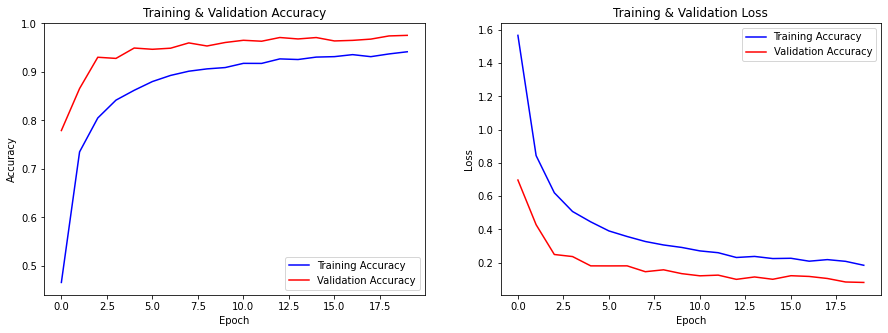

In [ ]:
evaluation_model(history)

In [ ]:
#Evaluasi Akurasi Model
model.evaluate(test_generator)

171/171 [==============================] - 10s 56ms/step - loss: 0.0819 - accuracy: 0.9755


[0.08186252415180206, 0.9755442142486572]

### **Step 6 : Predicting All Number Images**
Total 28.000 images

In [ ]:
#Filling CSV Test
submit = pd.read_csv('test.csv')

In [ ]:
submit.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_ = submit.shape[0]
predict_img = np.zeros((test_, 32, 32, 3))
predict_imgs = np.zeros((test_, 32, 32, 3))

for i in range(test_):
    predict_img[i,:28,:28,0] = submit.iloc[i, :].values.reshape(28,28)
    predict_img[i,:28,:28,1] = submit.iloc[i, :].values.reshape(28,28)
    predict_img[i,:28,:28,2] = submit.iloc[i, :].values.reshape(28,28)

for z in range(test_):
    predict_imgs[z] = cv2.resize(predict_img[z], (32, 32))

In [ ]:
def show_img(indx):
  img = predict_img[indx,:28,:28,0].reshape(28,28)
  plt.imshow(img, cmap='gist_gray')
  plt.colorbar()
  plt.show()

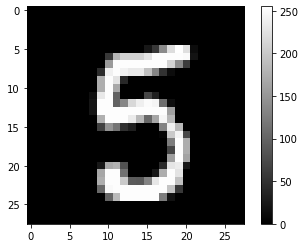

In [ ]:
show_img(10)

In [ ]:
test_images = predict_imgs
digit_predictions = model.predict_classes(test_images)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
digit_predictions.shape

(28000,)

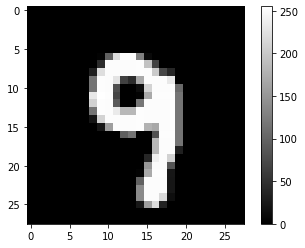

9


In [ ]:
indx = 77
show_img(indx)
print(digit_predictions[indx])